In [74]:
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
# This will automatically reload src/dtree.py every time you make changes and save the file
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
%matplotlib inline

In [76]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [77]:
df = pd.read_csv('./test.csv')

In [78]:
print(df.shape)
print(df.columns.to_list())
print(df.info())

(5000, 29)
['listing_id', 'title', 'make', 'model', 'description', 'manufactured', 'original_reg_date', 'reg_date', 'type_of_vehicle', 'category', 'transmission', 'curb_weight', 'power', 'fuel_type', 'engine_cap', 'no_of_owners', 'depreciation', 'coe', 'road_tax', 'dereg_value', 'mileage', 'omv', 'arf', 'opc_scheme', 'lifespan', 'eco_category', 'features', 'accessories', 'indicative_price']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   listing_id         5000 non-null   int64  
 1   title              5000 non-null   object 
 2   make               4373 non-null   object 
 3   model              5000 non-null   object 
 4   description        4889 non-null   object 
 5   manufactured       4939 non-null   float64
 6   original_reg_date  100 non-null    object 
 7   reg_date           4939 non-null   object 
 8   type_of_vehicl

In [79]:
d1 = df['original_reg_date'].isnull()
df['age'] = df['original_reg_date'].copy()
df['age'][d1] = df['reg_date'][d1]
d1 = df['age'].isnull()
df['age'][d1] = df['manufactured'][d1]

def extract_year(date):
    date = str(date)
    if len(date) != 4:
        if '.' in date and len(date) == 6:
            year = date[:-2]
        else:
            l = date.split('-')
            year = l[-1]
    return int(year)
df['age'] = 2021 - df['age'].map(extract_year)

G:\softwares\envs\4277lab\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
G:\softwares\envs\4277lab\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [80]:
# take out outliers acccording to scatter plot
# df = df[~((df['power'] > 200) & (df['engine_cap'] < 1000))]

df_valid = df.dropna(subset = ['power', 'engine_cap'])
powers = df_valid['power'].to_numpy()
caps = df_valid['engine_cap'].to_numpy()

# Find k data points with engine cap most similar to the power of x
# Calculate the median power of those k data points
# Set power of x to the calculated median
# Set k as the number of nearest data points we want to consider
k = 500

# Loop over each data point in our dataset
for idx, row in df.iterrows():
    if idx % 10000 == 0:
        print(idx)

    p, e = row['power'], row['engine_cap']
    
    if type(row["power"]) == float and pd.isna(row["power"]):
        diff = np.abs(caps - e)

        indices = np.argsort(diff)[:k]

        k_powers = powers[indices]

        avg = np.average(k_powers)

        # Set the weight value of the current row to the median
        df.at[idx, 'power'] = avg

0


In [81]:
# take out outliers acccording to scatter plot
# df = df[~((df['power'] > 200) & (df['engine_cap'] < 1000))]

df_valid = df.dropna(subset = ['power', 'engine_cap'])
powers = df_valid['power'].to_numpy()
caps = df_valid['engine_cap'].to_numpy()

# Find k data points with engine cap most similar to the power of x
# Calculate the median power of those k data points
# Set power of x to the calculated median
# Set k as the number of nearest data points we want to consider
k = 500

# Loop over each data point in our dataset
for idx, row in df.iterrows():
    if idx % 10000 == 0:
        print(idx)

    p, e = row['power'], row['engine_cap']
    
    if type(row["engine_cap"]) == float and pd.isna(row["engine_cap"]):

        diff = np.abs(powers - p)

        indices = np.argsort(diff)[:k]

        k_caps = caps[indices]

        avg = np.average(k_caps)

        # Set the weight value of the current row to the median
        df.at[idx, 'engine_cap'] = avg

0


In [82]:
print(df["engine_cap"].isnull().sum())

0


In [83]:
# coe: fill in missing value for coe according to: age and power
fill_arf = df[df.arf.isnull() & df.dereg_value.isnull()]['arf'].index.tolist()
for idx in fill_arf:
    omv = df.at[idx, 'omv']
    if omv < 20000:
        df.at[idx, 'arf'] = omv
    elif omv >= 20000 and omv <= 50000:
        df.at[idx, 'arf'] = (omv - 20000) * 1.40 + 20000
    else:
        df.at[idx, 'arf'] =  (omv - 50000) * 1.80 + 62000
print(len(df[df.arf.isnull() & df.dereg_value.isnull()]))
# df = df[~(df.arf.isnull() & df.dereg_value.isnull())] # remove values whose dereg_value cannot be calculated

2


In [84]:
# recalculate reg date: total months
def to_months(x):
    if type(x) == float and pd.isna(x):
        return 5 * 12
    mapper = {}
    all_m = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
    for i in range(12):
        mapper[all_m[i]] = i + 1
    if len(str(x)) < 11:
        return int(x)
    s = x.split('-')
    year = 2021 - int(s[-1])
    month = mapper[s[-2]]
    return year * 12 + month

df['age_in_month'] = df['reg_date'].map(to_months)

In [85]:
# for date missing both coe and dereg_value, record it's month engine and power
coe_to_search = []
to_search = df[df.coe.isnull() & df.dereg_value.isnull()]

for idx, row in to_search.iterrows():
    # category -> A / B
    power = row["power"]
    engine_cap = row["engine_cap"]
    cat = 2
    month = row["age_in_month"]
    if engine_cap <= 1600 and power <= 97:
        cat = 1
    coe_to_search.append((cat, month))

coe_to_search = list(set(coe_to_search))
print(len(coe_to_search))

44


In [86]:
t_to_coe = {}

for t in coe_to_search:
    t_to_coe[str(t)] = []

remains = df[~df.coe.isnull()]

for idx, row in remains.iterrows():
    if idx % 10000 == 0:
        print(idx)

    power = row["power"]
    engine_cap = row["engine_cap"]
    cat = 2
    month = row["age_in_month"]
    if engine_cap <= 1600 and power <= 97:
        cat = 1
    
    t = (cat, month)
    
    coe = row["coe"]
    if t in coe_to_search:
        t_to_coe[str(t)].append(coe)
        
c = 0
for idx, row in df.iterrows():
    power = row["power"]
    engine_cap = row["engine_cap"]
    cat = 2
    month = row["age_in_month"]
    if engine_cap <= 1600 and power <= 97:
        cat = 1
    t = str((cat, month))

    if type(row["coe"]) == float and pd.isna(row["coe"]):
        if t in t_to_coe:
            l = t_to_coe[t]
            if len(l) > 0:
                avg = sum(l) / len(l)
                df.at[idx, 'coe'] = avg
                c += 1
print(c)

214


In [87]:
print(df['coe'].isnull().sum())

31


In [88]:
df['coe'] = df['coe'].fillna(np.average(df['coe'].dropna())) ##

In [89]:
df['road_tax'] = df['road_tax'].fillna(np.average(df['road_tax'].dropna()))

In [90]:
df_valid = df.dropna(subset = ['road_tax', 'engine_cap'])
tax = df_valid['road_tax'].to_numpy()
caps = df_valid['engine_cap'].to_numpy()

# Find k data points with engine cap most similar to the power of x
# Calculate the median power of those k data points
# Set power of x to the calculated median
# Set k as the number of nearest data points we want to consider
k = 500

# Loop over each data point in our dataset
for idx, row in df.iterrows():
    if idx % 10000 == 0:
        print(idx)

    t, e = row['road_tax'], row['engine_cap']
    
    if type(row["road_tax"]) == float and pd.isna(row["road_tax"]):

        diff = np.abs(caps - e)

        indices = np.argsort(diff)[:k]

        k_caps = caps[indices]

        avg = np.average(k_caps)

        # Set the weight value of the current row to the median
        df.at[idx, 'road_tax'] = avg

0


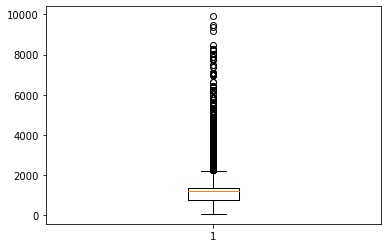

In [91]:
plt.figure()
plt.boxplot(df["road_tax"])
plt.show()

In [92]:
import math
for idx, row in df.iterrows():
    if type(row["dereg_value"]) == float and pd.isna(row["dereg_value"]):
        max_age = 10 * 12
        age = row["age_in_month"]
        time_left = max_age - age
        coe = row["coe"]
        omv = row["omv"]
        arf = row["arf"]
        parf_ratio = 0
        if age <  5 * 12:
            parf_ratio = 0.75
        elif age >= 5 * 12 and age < 10 * 12:
            parf_ratio = 0.75 - math.ceil((age - 5 * 12) / 12) * 0.05 
        coe_rebate = coe * time_left / 120
        dereg_value = parf_ratio * arf + coe_rebate
        if dereg_value <= 0:
            dereg_value = 0
        df.at[idx, "dereg_value"] = dereg_value

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   listing_id         5000 non-null   int64  
 1   title              5000 non-null   object 
 2   make               4373 non-null   object 
 3   model              5000 non-null   object 
 4   description        4889 non-null   object 
 5   manufactured       4939 non-null   float64
 6   original_reg_date  100 non-null    object 
 7   reg_date           4939 non-null   object 
 8   type_of_vehicle    5000 non-null   object 
 9   category           5000 non-null   object 
 10  transmission       5000 non-null   object 
 11  curb_weight        4844 non-null   float64
 12  power              5000 non-null   float64
 13  fuel_type          1051 non-null   object 
 14  engine_cap         5000 non-null   float64
 15  no_of_owners       4944 non-null   float64
 16  depreciation       4868 

In [94]:
avg = df['depreciation'].dropna().median()
df['depreciation'] = df['depreciation'].fillna(avg)##

In [95]:
print(df.columns.to_list())

['listing_id', 'title', 'make', 'model', 'description', 'manufactured', 'original_reg_date', 'reg_date', 'type_of_vehicle', 'category', 'transmission', 'curb_weight', 'power', 'fuel_type', 'engine_cap', 'no_of_owners', 'depreciation', 'coe', 'road_tax', 'dereg_value', 'mileage', 'omv', 'arf', 'opc_scheme', 'lifespan', 'eco_category', 'features', 'accessories', 'indicative_price', 'age', 'age_in_month']


In [96]:
df['mileage'] = df['mileage'].fillna(df['mileage'].dropna().median())

In [97]:
# drop irrelevant
df = df.drop(columns = ['curb_weight', 'coe', 'omv', 'arf', 'original_reg_date','reg_date', 'age_in_month', 'opc_scheme', 'listing_id', 'indicative_price', 'age', 'manufactured', 'no_of_owners', 'lifespan', 'eco_category', 'accessories', 'engine_cap'])

In [98]:
print(df.shape)

(5000, 14)


In [99]:
df.head()

,title,make,model,description,type_of_vehicle,category,transmission,power,fuel_type,depreciation,road_tax,dereg_value,mileage,features
0,BMW X6 xDrive35i Sunroof (New 10-yr COE),bmw,x6,"owner consignment unit, viewing strictly by ap...",suv,coe car,auto,225.0,NaN,14870.0,2362.0,37542.2875,122000.0,"smooth inline 6 3.0l turbo n55 engine, high sp..."
1,Porsche 911 Carrera S Coupe 3.8A PDK (COE till...,porsche,911,the 911 carrera s displacing 3.8 litres with m...,sports car,"coe car, direct owner sale",auto,283.0,NaN,31920.0,4366.0,23211.0000,125000.0,responsive flat six 3.8 litres of naturally as...
2,Porsche Macan Diesel S 3.0A PDK,porsche,macan,comes with agent warranty till january 2022. a...,suv,"parf car, premium ad car",auto,190.0,diesel,26640.0,3336.0,102072.0000,55965.0,black exterior with black interior. comes with...
3,BMW 5 Series 530i Luxury,bmw,530i,a careful owner upgraded to a porsche macan. t...,luxury sedan,"parf car, sgcarmart warranty cars",auto,185.0,NaN,19390.0,1210.0,73330.0000,100000.0,"2.0l bmw inline 4 cylinder twin power turbo, 2..."
4,Honda Vezel 1.5A X,NaN,vezel,100% non phv-unit! excellent condition and wel...,suv,parf car,auto,96.0,NaN,9620.0,682.0,34555.0000,62000.0,"1.5l dohc i-vtec engine, 128 bhp, cvt auto tra..."


In [100]:
df.to_csv('test_num_cleaned.csv')  